In [1]:
import cv2
import numpy as np
import os

In [2]:
img = '/mnt/chromeos/GoogleDrive/MyDrive/Research/greyNormFrames/frame0520.jpg'

In [3]:
os.path.exists(img)

True

In [4]:
frame = cv2.imread(img)

In [5]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Threshold (result will already be uint8 if source is uint8)
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Make sure it's uint8 single-channel
binary = binary.astype("uint8")

# Now it works:
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [6]:
# Find contours of the blob(s)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assuming largest contour = blob of interest
contour = max(contours, key=cv2.contourArea)

# Compute area in pixels
area = cv2.contourArea(contour)

# Compute equivalent radius (if blob ~ circular)
radius = np.sqrt(area / np.pi)

print("Blob area:", area, "pixels")
print("Equivalent radius:", radius)


Blob area: 195069.5 pixels
Equivalent radius: 249.18376821721145


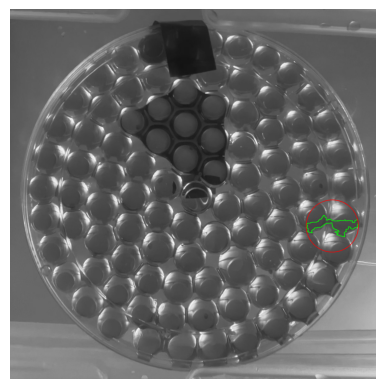

In [7]:

# Step 1: Blur to reduce bead edges
blur = cv2.GaussianBlur(gray, (7,7), 0)

# Step 2: Adaptive threshold (handles uneven lighting)
binary = cv2.adaptiveThreshold(
    blur, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    151,   # block size (odd number, tweak this)
    25    # constant subtracted, tweak to control sensitivity
)

# Step 3: Morphological closing (fills small gaps)
kernel = np.ones((5,5), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# Step 4: Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Largest contour = main blob
    contour = max(contours, key=cv2.contourArea)

    # Draw contour in green
    cv2.drawContours(frame, [contour], -1, (0,255,0), 2)

    # Draw enclosing circle in red
    (x,y), radius = cv2.minEnclosingCircle(contour)
    center = (int(x), int(y))
    radius = int(radius)
    cv2.circle(frame, center, radius, (0,0,255), 2)

# Show result resized to fit screen
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


<IPython.core.display.Javascript object>


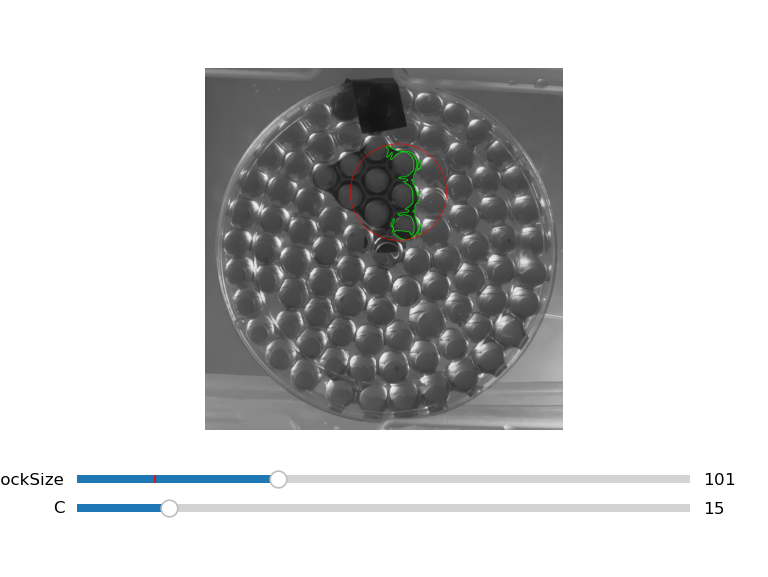

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
%matplotlib notebook


# Load your frame
frame = cv2.imread(img)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)

# Initial parameters
init_blockSize = 41
init_C = 15

# Function to update the image
def update(val):
    blockSize = int(slider_blockSize.val)
    C = int(slider_C.val)

    # Ensure blockSize is odd and >= 3
    if blockSize % 2 == 0:
        blockSize += 1
    if blockSize < 3:
        blockSize = 3

    # Adaptive threshold
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize,
        C
    )

    # Morphological closing
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Find largest contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    display = frame.copy()
    if contours:
        contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(display, [contour], -1, (0,255,0), 2)
        (x,y), radius = cv2.minEnclosingCircle(contour)
        cv2.circle(display, (int(x),int(y)), int(radius), (0,0,255), 2)

    display_rgb = cv2.cvtColor(display, cv2.COLOR_BGR2RGB)
    im.set_data(display_rgb)
    fig.canvas.draw_idle()

# Set up Matplotlib figure and axes
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.25)
display_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
im = ax.imshow(display_rgb)
ax.axis('off')

# Sliders for blockSize and C
ax_blockSize = plt.axes([0.1, 0.15, 0.8, 0.03])
ax_C = plt.axes([0.1, 0.1, 0.8, 0.03])
slider_blockSize = Slider(ax_blockSize, 'blockSize', 3, 301, valinit=init_blockSize, valstep=2)
slider_C = Slider(ax_C, 'C', 0, 100, valinit=init_C, valstep=1)

# Callbacks
slider_blockSize.on_changed(update)
slider_C.on_changed(update)

plt.show()
